In [1]:
import numpy as np
import finesse
import matplotlib.pyplot as plt
finesse.init_plotting()

base = finesse.Model()
base.parse("""
variable ITM_T 0.014
variable L_ARM 40k
variable FC_detune 7.3 # Hz

l l1 P=165
link(l1, PRM)
# ------------------------------------------------------------------------------
# Power recycling cavity
# ------------------------------------------------------------------------------
m PRM T=0.03 L=40u phi=0
s PRC PRM.p2 BS.p1 L=53.0
bs BS R=0.5 T=0.5
# ------------------------------------------------------------------------------
# X-arm
# ------------------------------------------------------------------------------
s lx BS.p3 ITMX.p1 L=0
m ITMX T=ITM_T L=0u phi=0
s LX ITMX.p2 ETMX.p1 L=L_ARM
m ETMX T=5u L=40u phi=0
# ------------------------------------------------------------------------------
# Y-arm
# ------------------------------------------------------------------------------
s ly BS.p2 ITMY.p1 L=0
m ITMY T=ITM_T L=0u phi=90
s LY ITMY.p2 ETMY.p1 L=L_ARM
m ETMY T=5u L=40u phi=90
# Signal recycling cavity
s SRC BS.p4 SRM.p1 L=20
m SRM T=0.02 L=0 phi=0
# ------------------------------------------------------------------------------
# Output optics
# ------------------------------------------------------------------------------
dbs OFI
link(SRM.p2, OFI.p1)
readout_dc AS OFI.p3.o
# ------------------------------------------------------------------------------
# suspensions
# ------------------------------------------------------------------------------
free_mass ITMX_sus ITMX mass=320
free_mass ETMX_sus ETMX mass=320
free_mass ITMY_sus ITMY mass=320
free_mass ETMY_sus ETMY mass=320
# ------------------------------------------------------------------------------
# Degrees of Freedom
# ------------------------------------------------------------------------------
dof STRAIN LX.dofs.h +1  LY.dofs.h -1

# signal generator
sgen sig STRAIN

qnoised NSR AS.p1.i nsr=True

fsig(1)
""")

In [2]:
model = base.deepcopy()
model.parse("""
sq sqz db=10
link(sqz, OFI.p2)
""")

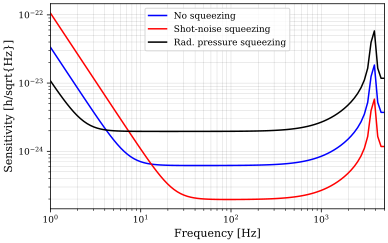

In [3]:
with model.temporary_parameters():
    # No squeezing
    model.sqz.db = 0
    model.sqz.angle = 0
    sol_no_sqz = model.run("xaxis(fsig, log, 1, 5k, 100)")
    # Squeezing
    model.sqz.db = 10
    model.sqz.angle = 90
    sol_shot_sqz = model.run("xaxis(fsig, log, 1, 5k, 100)")
    # Squeezing
    model.sqz.db = 10
    model.sqz.angle = 0
    sol_rp_sqz = model.run("xaxis(fsig, log, 1, 5k, 100)")

plt.loglog(sol_no_sqz.x1, abs(sol_no_sqz['NSR']), label='No squeezing')
plt.loglog(sol_shot_sqz.x1, abs(sol_shot_sqz['NSR']), label='Shot-noise squeezing')
plt.loglog(sol_rp_sqz.x1, abs(sol_rp_sqz['NSR']), label='Rad. pressure squeezing')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [h/sqrt{Hz}]");

(45+(57.29577951308232*arctan((((fsig.f)**(2)-(FC_detune)**(2))/((fsig.f)**(2)+(FC_detune)**(2)))))) degrees


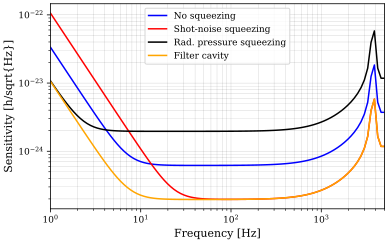

In [4]:
with model.temporary_parameters():
    model.FC_detune.value = 7.2
    model.sqz.db = 10
    # Give the variable references shorter names
    fsig = model.fsig.f.ref
    delta_f = model.FC_detune.ref
    # set the squeezing angle to be a symbolic function
    model.sqz.angle = (
        45 + 180/np.pi * np.arctan((fsig**2-delta_f**2)/(fsig**2 + delta_f**2))
    )
    print(model.sqz.angle) # print to see how it turned out
    sol_fc_sqz = model.run("xaxis(fsig, log, 1, 5k, 100)")

plt.loglog(sol_no_sqz.x1, abs(sol_no_sqz['NSR']), label='No squeezing')
plt.loglog(sol_shot_sqz.x1, abs(sol_shot_sqz['NSR']), label='Shot-noise squeezing')
plt.loglog(sol_rp_sqz.x1, abs(sol_rp_sqz['NSR']), label='Rad. pressure squeezing')
plt.loglog(sol_fc_sqz.x1, abs(sol_fc_sqz['NSR']), label='Filter cavity')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [h/sqrt{Hz}]");

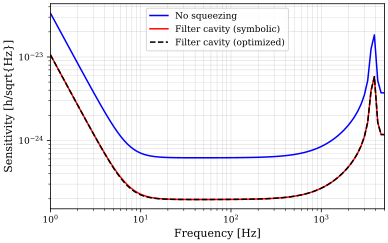

In [5]:
# Run an optimiser to find ideal rotation
sol_opt_sqz = model.run("xaxis(fsig, log, 1, 5k, 100, pre_step=minimize(NSR, sqz.angle))")

plt.loglog(sol_no_sqz.x1, abs(sol_no_sqz['NSR']), label='No squeezing')
plt.loglog(sol_fc_sqz.x1, abs(sol_fc_sqz['NSR']), label='Filter cavity (symbolic)')
plt.loglog(sol_opt_sqz.x1, abs(sol_opt_sqz['NSR']), label='Filter cavity (optimized)', ls='--')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [h/sqrt{Hz}]");

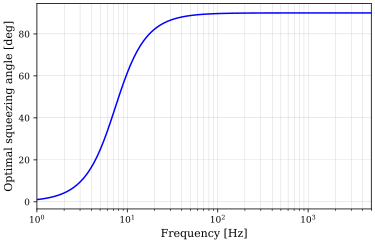

In [6]:
# Extract every optimisisation solution (`x`) from all the pre-step minimize actions
opt_angle = sol_opt_sqz["pre_step", "minimize"].x
plt.semilogx(sol_opt_sqz.x1, opt_angle)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Optimal squeezing angle [deg]");

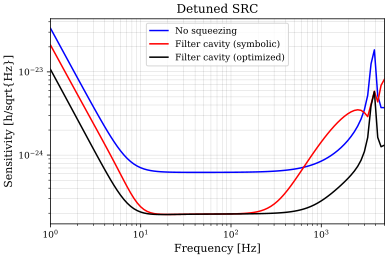

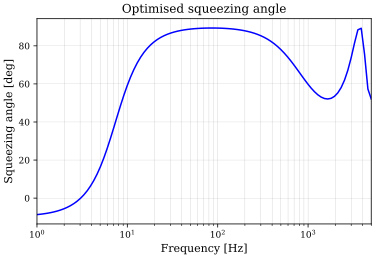

In [7]:
with model.temporary_parameters():
    model.FC_detune.value = 7.2
    model.SRM.phi += 0.1 # Detune slightly
    model.sqz.db = 10
    # Give the variable references shorter names
    fsig = model.fsig.f.ref
    delta_f = model.FC_detune.ref
    # set the squeezing angle to be a symbolic function
    model.sqz.angle = (
        45 + 180/np.pi * np.arctan((fsig**2-delta_f**2)/(fsig**2 + delta_f**2))
    )
    sol_fc_sqz = model.run("xaxis(fsig, log, 1, 5k, 100)")
    # Run an optimiser to find ideal rotation
    model.sqz.angle = 0
    sol_opt_sqz = model.run("xaxis(fsig, log, 1, 5k, 100, pre_step=minimize(NSR, sqz.angle))")

    plt.loglog(sol_no_sqz.x1, abs(sol_no_sqz['NSR']), label='No squeezing')
    plt.loglog(sol_fc_sqz.x1, abs(sol_fc_sqz['NSR']), label='Filter cavity (symbolic)')
    plt.loglog(sol_opt_sqz.x1, abs(sol_opt_sqz['NSR']), label='Filter cavity (optimized)')
    plt.legend()
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Sensitivity [h/sqrt{Hz}]");
    plt.title("Detuned SRC");
    plt.figure()
    # Extract every optimisisation solution (`x`) from all the pre-step minimize actions
    opt_angle = sol_opt_sqz["pre_step", "minimize"].x
    plt.semilogx(sol_opt_sqz.x1, opt_angle)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Squeezing angle [deg]")
    plt.title("Optimised squeezing angle")

In [8]:
model = base.deepcopy() # make a copy so we can add extra features
model.parse("""
sq sqz db=10
dbs FI
m FC1 L=0 T=0.0015
s sFC FC1.p2 FC2.p1 L=4e3
m FC2 L=0 T=0 phi=-0.022

link(sqz, FI.p1)
link(FI.p3, FC1)
link(FI.p4, OFI.p2)
""")

FC1.T = 0.0016474843098274795
FC2.phi = -0.023938758321481367 degrees
FC L = 3893.1908972900965 m


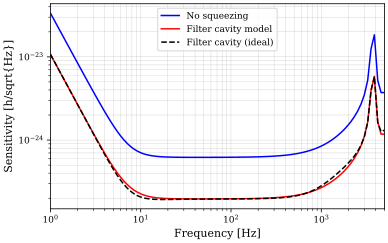

In [9]:
model.sqz.db = 10
model.sqz.angle = 90
model.FC1.T = 0.0015
model.FC1.R = 1-model.FC1.T.ref # Make sure we update the R correctly when we change T
model.FC2.phi = -0.022
# Optimise the NSR at the corner frequency
model.fsig.f = 7.2
# Run the optimisation a few times to reach a better level
for _ in range(3):
    model.run("minimize(NSR, [FC1.T, FC2.phi, sFC.L])")
# finally compute the NSR
sol_fc2_sqz = model.run("xaxis(fsig, log, 1, 5k, 100)")

plt.loglog(sol_no_sqz.x1, abs(sol_no_sqz['NSR']), label='No squeezing')
plt.loglog(sol_fc2_sqz.x1, abs(sol_fc2_sqz['NSR']), label='Filter cavity model')
plt.loglog(sol_opt_sqz.x1, abs(sol_opt_sqz['NSR']), label='Filter cavity (ideal)', ls='--')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [h/sqrt{Hz}]");
print("FC1.T =", model.FC1.T)
print("FC2.phi =", model.FC2.phi)
print("FC L =", model.sFC.L)